In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

np.random.seed(1234)

In [145]:
df = pd.read_csv('../rotterdam.csv')
df = df.dropna()

In [146]:
CUTOFF_DAYS = 1825

df['target'] = np.where((df['recur'] == 1) & (df['rtime'] <= CUTOFF_DAYS), 1, 0)

valid_mask = (df['target'] == 1) | ((df['target'] == 0) & (df['rtime'] >= CUTOFF_DAYS))
df_clean = df[valid_mask].copy()

print(f"Original shape: {df.shape}")
print(f"Shape after filtering (follow-up >= 5y): {df_clean.shape}")
print(f"\nClass Balance (Recurrence Rate AFTER 5y):")
print(df_clean['target'].value_counts(normalize=True))
print(f"\nRecurrence counts:")
print(df_clean['target'].value_counts())

Original shape: (2982, 17)
Shape after filtering (follow-up >= 5y): (2355, 17)

Class Balance (Recurrence Rate AFTER 5y):
target
0    0.667091
1    0.332909
Name: proportion, dtype: float64

Recurrence counts:
target
0    1571
1     784
Name: count, dtype: int64


In [147]:
df_clean['nodes_log'] = np.log1p(df_clean['nodes'])
df_clean['er_log'] = np.log1p(df_clean['er'])
df_clean['pgr_log'] = np.log1p(df_clean['pgr'])

# Nodes as categorical groups: 0, 1-3, 4-9, 10+
node_bins = [-0.1, 0, 3, 9, np.inf]
node_labels = ['0', '1-3', '4-9', '10+']
df_clean['nodes_cat'] = pd.cut(df_clean['nodes'], bins=node_bins, labels=node_labels, right=True)

num_features = ['age', 'nodes_log', 'pgr_log', 'er_log']
cat_features = ['grade', 'size', 'meno', 'nodes_cat']

X = df_clean[num_features + cat_features]
y = df_clean['target']

# Statistical Tests on Features

We'll perform multiple statistical tests to understand the relationships between baseline variables and recurrence outcome.

In [148]:
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency, spearmanr, pearsonr
from statsmodels.formula.api import logit
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

## 1. Descriptive Statistics by Recurrence Status

In [149]:
numerical_vars = ['age', 'nodes_log', 'er_log', 'pgr_log']

print("\n" + "="*80)
print("NUMERICAL VARIABLES - Descriptive Statistics")
print("="*80)

desc_stats = pd.DataFrame()
for var in numerical_vars:
    recur_yes = df_clean[y == 1][var]
    recur_no = df_clean[y == 0][var]
    
    desc_stats = pd.concat([desc_stats, pd.DataFrame({
        'Variable': [var],
        'No Recur (Mean±SD)': [f"{recur_no.mean():.2f}±{recur_no.std():.2f}"],
        'Recurrence (Mean±SD)': [f"{recur_yes.mean():.2f}±{recur_yes.std():.2f}"],
        'No Recur (Median[IQR])': [f"{recur_no.median():.2f}[{recur_no.quantile(0.25):.2f}-{recur_no.quantile(0.75):.2f}]"],
        'Recurrence (Median[IQR])': [f"{recur_yes.median():.2f}[{recur_yes.quantile(0.25):.2f}-{recur_yes.quantile(0.75):.2f}]"],
    })], ignore_index=True)

print(desc_stats.to_string(index=False))


NUMERICAL VARIABLES - Descriptive Statistics
 Variable No Recur (Mean±SD) Recurrence (Mean±SD) No Recur (Median[IQR]) Recurrence (Median[IQR])
      age        54.53±12.18          54.53±13.65     54.00[45.00-64.00]       54.00[43.00-65.00]
nodes_log          0.52±0.75            1.47±1.02        0.00[0.00-1.10]          1.61[0.69-2.30]
   er_log          3.86±1.99            3.59±2.09        4.23[2.71-5.33]          4.00[2.08-5.22]
  pgr_log          3.68±2.21            3.05±2.21        4.17[2.08-5.47]          3.24[1.10-4.88]


## 2. Statistical Tests for Continuous Variables

**Tests performed:**
- **T-test (parametric)**: Compares means between two groups (assumes normality and equal variance)
- **Mann-Whitney U test (non-parametric)**: Compares distributions when normality assumption is violated

In [150]:
print("\n" + "="*80)
print("HYPOTHESIS TESTS FOR CONTINUOUS VARIABLES")
print("="*80)
print("\nNull Hypothesis (H0): No difference between recurrence groups")
print("Alternative Hypothesis (H1): There is a significant difference\n")

test_results = []

for var in numerical_vars:
    recur_yes = df_clean[y == 1][var].dropna()
    recur_no = df_clean[y == 0][var].dropna()
    
    # T-test (assumes normality)
    t_stat, t_pval = ttest_ind(recur_yes, recur_no)
    
    # Mann-Whitney U test (non-parametric alternative)
    u_stat, u_pval = mannwhitneyu(recur_yes, recur_no, alternative='two-sided')
    
    test_results.append({
        'Variable': var,
        'T-test p-value': f"{t_pval:.4f}",
        'Mann-Whitney p-value': f"{u_pval:.4f}",
        'Significant (α=0.05)?': '***' if t_pval < 0.05 else 'No'
    })

results_df = pd.DataFrame(test_results)
print(results_df.to_string(index=False))

print("\n*** p < 0.05 indicates statistical significance")


HYPOTHESIS TESTS FOR CONTINUOUS VARIABLES

Null Hypothesis (H0): No difference between recurrence groups
Alternative Hypothesis (H1): There is a significant difference

 Variable T-test p-value Mann-Whitney p-value Significant (α=0.05)?
      age         0.9978               0.8222                    No
nodes_log         0.0000               0.0000                   ***
   er_log         0.0020               0.0060                   ***
  pgr_log         0.0000               0.0000                   ***

*** p < 0.05 indicates statistical significance


## 3. Statistical Tests for Categorical Variables

**Test performed:**
- **Chi-square test**: Tests for independence between categorical variables

In [151]:
categorical_vars = ['grade', 'size', 'meno', 'nodes_cat']

print("\n" + "="*80)
print("CATEGORICAL VARIABLES - Chi-Square Tests")
print("="*80)
print("\nNull Hypothesis (H0): No association between variable and recurrence")
print("Alternative Hypothesis (H1): There is an association\n")

chi_results = []

for var in categorical_vars:
    # Create contingency table
    contingency = pd.crosstab(df_clean[var], y)
    
    # Perform chi-square test
    chi2, p_val, dof, expected = chi2_contingency(contingency)
    
    # Display contingency table
    print(f"\n{var.upper()}")
    print("-" * 50)
    print(contingency)
    
    # Calculate proportions
    prop_table = pd.crosstab(df_clean[var], y, normalize='index')
    print("\nProportions (row percentages):")
    print(prop_table.round(3))
    
    print(f"\nChi-square statistic: {chi2:.4f}")
    print(f"P-value: {p_val:.4f}")
    print(f"Degrees of freedom: {dof}")
    print(f"Significant (α=0.05)? {'***YES' if p_val < 0.05 else 'No'}")
    
    chi_results.append({
        'Variable': var,
        'Chi2': f"{chi2:.4f}",
        'P-value': f"{p_val:.4f}",
        'Significant?': '***' if p_val < 0.05 else 'No'
    })


CATEGORICAL VARIABLES - Chi-Square Tests

Null Hypothesis (H0): No association between variable and recurrence
Alternative Hypothesis (H1): There is an association


GRADE
--------------------------------------------------
target     0    1
grade            
2        507  121
3       1064  663

Proportions (row percentages):
target      0      1
grade               
2       0.807  0.193
3       0.616  0.384

Chi-square statistic: 74.9732
P-value: 0.0000
Degrees of freedom: 1
Significant (α=0.05)? ***YES

SIZE
--------------------------------------------------
target    0    1
size            
20-50   600  424
<=20    892  203
>50      79  157

Proportions (row percentages):
target      0      1
size                
20-50   0.586  0.414
<=20    0.815  0.185
>50     0.335  0.665

Chi-square statistic: 255.0462
P-value: 0.0000
Degrees of freedom: 2
Significant (α=0.05)? ***YES

MENO
--------------------------------------------------
target    0    1
meno            
0       724  344
1   

## 4. Univariate Logistic Regression Analysis

Tests the association between each feature and recurrence outcome.

In [152]:
print("\n" + "="*80)
print("UNIVARIATE LOGISTIC REGRESSION (Odds Ratios)")
print("="*80)

logistic_results = []

# Numerical features
for var in numerical_vars:
    try:
        X_temp = df_clean[[var]].copy()
        X_temp = sm.add_constant(X_temp)
        
        model = sm.Logit(y, X_temp).fit(disp=0)
        
        coef = model.params[var]
        or_val = np.exp(coef)
        pval = model.pvalues[var]
        ci_lower = np.exp(coef - 1.96 * model.bse[var])
        ci_upper = np.exp(coef + 1.96 * model.bse[var])
        
        logistic_results.append({
            'Variable': var,
            'Coeff': f"{coef:.4f}",
            'OR': f"{or_val:.4f}",
            '95% CI': f"({ci_lower:.4f}, {ci_upper:.4f})",
            'P-value': f"{pval:.4f}",
            'Sig': '***' if pval < 0.05 else ''
        })
    except Exception as e:
        print(f"Skipping {var} (num): {e}")
        continue

# Categorical features (one-hot with reference)
for var in categorical_vars:
    try:
        dummies = pd.get_dummies(df_clean[var], prefix=var, drop_first=True, dtype=float)
        if dummies.empty:
            continue
        X_temp = sm.add_constant(dummies)
        model = sm.Logit(y.astype(float), X_temp).fit(disp=0)
        for col in dummies.columns:
            coef = model.params[col]
            or_val = np.exp(coef)
            pval = model.pvalues[col]
            ci_lower = np.exp(coef - 1.96 * model.bse[col])
            ci_upper = np.exp(coef + 1.96 * model.bse[col])
            level = col.replace(f"{var}_", "")
            logistic_results.append({
                'Variable': f"{var}={level}",
                'Coeff': f"{coef:.4f}",
                'OR': f"{or_val:.4f}",
                '95% CI': f"({ci_lower:.4f}, {ci_upper:.4f})",
                'P-value': f"{pval:.4f}",
                'Sig': '***' if pval < 0.05 else ''
            })
    except Exception as e:
        print(f"Skipping {var} (cat): {e}")
        continue

logistic_df = pd.DataFrame(logistic_results)
print(logistic_df.to_string(index=False))
print("\n*** p < 0.05")


UNIVARIATE LOGISTIC REGRESSION (Odds Ratios)
     Variable   Coeff      OR             95% CI P-value Sig
          age -0.0000  1.0000   (0.9933, 1.0068)  0.9978    
    nodes_log  1.1106  3.0361   (2.7342, 3.3713)  0.0000 ***
       er_log -0.0660  0.9361   (0.8976, 0.9763)  0.0021 ***
      pgr_log -0.1272  0.8806   (0.8472, 0.9153)  0.0000 ***
      grade=3  0.9597  2.6109   (2.0937, 3.2559)  0.0000 ***
    size=<=20 -1.1331  0.3220   (0.2645, 0.3921)  0.0000 ***
     size=>50  1.0340  2.8123   (2.0884, 3.7870)  0.0000 ***
       meno=1  0.0892  1.0933   (0.9201, 1.2991)  0.3106    
nodes_cat=1-3  0.7549  2.1273   (1.6774, 2.6980)  0.0000 ***
nodes_cat=4-9  1.9924  7.3331   (5.6849, 9.4592)  0.0000 ***
nodes_cat=10+  2.9815 19.7173 (13.9131, 27.9428)  0.0000 ***

*** p < 0.05


## 5. Correlation Analysis

Spearman correlation for examining relationships between continuous variables.


CORRELATION WITH RECURRENCE OUTCOME
 Variable Spearman ρ Spearman p-val Pearson r Pearson p-val
      age    -0.0046         0.8223   -0.0001        0.9978
nodes_log     0.4487         0.0000    0.4694        0.0000
   er_log    -0.0566         0.0060   -0.0636        0.0020
  pgr_log    -0.1386         0.0000   -0.1338        0.0000

CORRELATION MATRIX HEATMAP


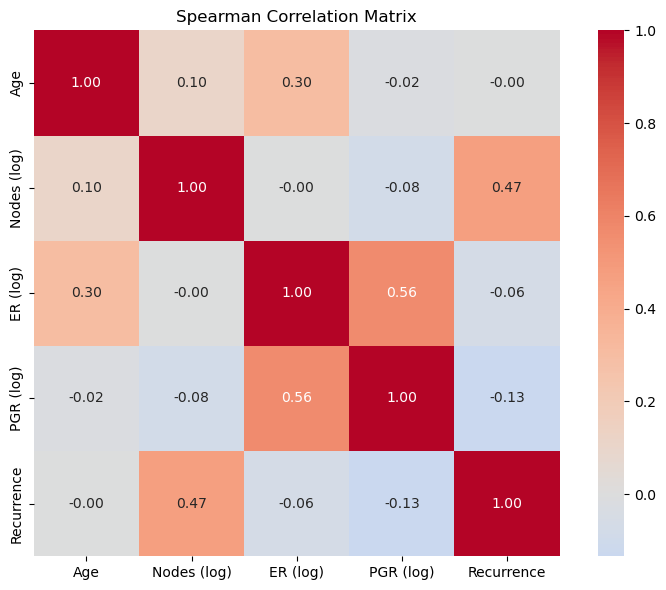

In [153]:
print("\n" + "="*80)
print("CORRELATION WITH RECURRENCE OUTCOME")
print("="*80)

correlation_results = []

for var in numerical_vars:
    spear_corr, spear_pval = spearmanr(df_clean[var].dropna(), y[df_clean[var].notna()])
    pear_corr, pear_pval = pearsonr(df_clean[var].dropna(), y[df_clean[var].notna()])
    
    correlation_results.append({
        'Variable': var,
        'Spearman ρ': f"{spear_corr:.4f}",
        'Spearman p-val': f"{spear_pval:.4f}",
        'Pearson r': f"{pear_corr:.4f}",
        'Pearson p-val': f"{pear_pval:.4f}",
    })

corr_df = pd.DataFrame(correlation_results)
print(corr_df.to_string(index=False))

# Visualize correlations
print("\n" + "="*80)
print("CORRELATION MATRIX HEATMAP")
print("="*80)

# Create correlation matrix including all numerical variables
corr_data = df_clean[numerical_vars + ['target']].copy()
corr_data.columns = ['Age', 'Nodes (log)', 'ER (log)', 'PGR (log)', 'Recurrence']

plt.figure(figsize=(8, 6))
sns.heatmap(corr_data.corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0, square=True)
plt.title('Spearman Correlation Matrix')
plt.tight_layout()
plt.show()

## 6. Multicollinearity Check (VIF Analysis)

In [154]:
print("\n" + "="*80)
print("VARIANCE INFLATION FACTOR (VIF) - Multicollinearity Check")
print("="*80)
print("\nVIF > 5: indicates potential multicollinearity problems")
print("VIF > 10: strong multicollinearity (variable should be removed)\n")

# Calculate VIF for numerical features
X_vif = df_clean[numerical_vars].copy()
X_vif = sm.add_constant(X_vif)

vif_data = pd.DataFrame()
vif_data["Variable"] = numerical_vars
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i+1) for i in range(len(numerical_vars))]

print(vif_data.to_string(index=False))


VARIANCE INFLATION FACTOR (VIF) - Multicollinearity Check

VIF > 5: indicates potential multicollinearity problems
VIF > 10: strong multicollinearity (variable should be removed)

 Variable      VIF
      age 1.173063
nodes_log 1.017566
   er_log 1.705423
  pgr_log 1.562666


## KEY FINDINGS:

1. AGE
   - NOT significantly associated with recurrence (p=0.998)
   - Mean age similar in both groups (~54.5 years)
   - Not a significant predictor

2. LYMPH NODES
   - Continuous log scale: *** highly significant (p<0.001); OR = 3.04 (95% CI: 2.73-3.37)
   - Categorical groups (ref = 0 nodes):
       * 1-3 nodes: OR = 2.13 (95% CI: 1.68-2.70)
       * 4-9 nodes: OR = 7.33 (95% CI: 5.68-9.46)
       * 10+ nodes: OR = 19.72 (95% CI: 13.91-27.94)
   - Recurrence proportions rise steadily across categories (0: 16.4%, 1-3: 29.4%, 4-9: 58.9%, 10+: 79.4%)
   - Strong positive correlation with recurrence (ρ=0.45)

3. ESTROGEN RECEPTORS (er_log)
   - *** Significant (p<0.01)
   - Higher ER levels = LOWER recurrence risk
   - OR = 0.94 (95% CI: 0.90-0.98)
   - Weak negative correlation (ρ=-0.06)

4. PROGESTERONE RECEPTORS (pgr_log)
   - *** Highly significant (p<0.001)
   - Higher PGR levels = LOWER recurrence risk
   - OR = 0.88 (95% CI: 0.85-0.92)
   - Weak-moderate negative correlation (ρ=-0.14)

5. TUMOR GRADE
   - *** Highly significant (p<0.001)
   - Grade 3 vs Grade 2: OR = 2.61 (95% CI: 2.09-3.26)
   - Grade 3 recurrence: 38.4% vs Grade 2: 19.3%

6. TUMOR SIZE
   - *** Highly significant (p<0.001)
   - Size >50mm: 66.5% recurrence (highest risk)
   - Size ≤20mm: 18.5% recurrence (lowest risk)
   - Size 20-50mm: 41.4% recurrence

7. MENOPAUSAL STATUS
   - NOT significant (p=0.332)
   - Similar recurrence rates: 32.2% (premenopausal) vs 34.2% (postmenopausal)

MULTICOLLINEARITY:
   - All VIF < 2, no multicollinearity issues
   - Features are independent

CLINICAL SIGNIFICANCE:
   - Lymph node burden is the strongest driver; risk escalates sharply with higher node categories
   - Tumor size and grade remain key risk factors
   - Higher ER/PGR levels are protective
   - Age and menopausal status are not meaningful predictors in this dataset

In [155]:
from sklearn.model_selection import KFold